<h1><center>SimpleITK Tutorial</center></h1>

# Deformable Registration

Author: José D. Tascón-Vidarte \
Email: jota@di.ku.dk \
University of Copenhagen

Objectives:
- Learn to implement image registration with SimpleITK

The documentation of SimpleITK is available at https://itk.org/SimpleITKDoxygen100/html/index.html

This tutorial is based on the Notebooks provided by the Insight Software Consortium. http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks

## The Registration Problem

Having two images, a reference (fixed) image $I_{1}(x)$ and an input (moving) image $I_{2}(x)$, find a transformation $\phi(x)$ that maps $I_{2}$ into image $I_{1}$ in order to them to be similar.

Therefore, registration consist of finding a transformation between images. In this notebook only rigid or affine transformation are used.

In the previous tutorial notebooks the registration framework of SimpleITK was presented. Those examples only have rigid or affine transformations. In this tutorial deformable transformations are found with the supported features of SimpleITK.

##  Cloning files

Open the files to be used from github.

In [1]:
# !rm -rf /content/registration_tutorial/
# !git clone https://github.com/josetascon/registration_tutorial.git

## Import Libraries

Import the libraries to be used.

In [2]:
# !pip install simpleitk           # install simpleitk in colabs

import SimpleITK as sitk         # simpleitk library
import sys                       # sys library, used to include local py files
import numpy as np               # array and matrix library
import matplotlib.pyplot as plt  # plot library

# sys.path.insert(0, '/content/registration_tutorial/') # local library path
from local_utils import * # local file

## Read the Images

We will use toy example images in this notebook. The first two correspond to a sphere and an splash.


===== Image Information =====
Pixel type: 		32-bit float
Pixel channels: 	1
Dimensions: 		2
Size: 			(256, 256)
Length (mm): 		(1.0, 1.0)
Total Elements: 	65536



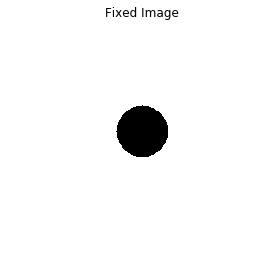


===== Image Information =====
Pixel type: 		32-bit float
Pixel channels: 	1
Dimensions: 		2
Size: 			(256, 256)
Length (mm): 		(1.0, 1.0)
Total Elements: 	65536



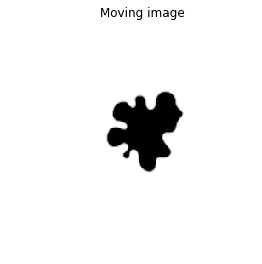

In [3]:
dimension = 2

prefix = './images/'
# prefix = '/content/registration_tutorial/images/'

# Read the images
fixed_image = sitk.ReadImage(prefix + 'circle.png', sitk.sitkFloat32)
moving_image = sitk.ReadImage(prefix + 'splash.png', sitk.sitkFloat32)

print(image_info(fixed_image))
imshow_2d(fixed_image, 'Fixed Image')

print(image_info(moving_image))
imshow_2d(moving_image, 'Moving image')

## Demons Algorithm
One of the fastest algorithm for deformable registration is the demons algorithm. Presented  by Thirion in 1995/1998, offers a simple solution to registration. This algorithm is viewed as a diffusion process from one image to the other. The optimization perform with the demons algorithm is similar to a optical flow equation. 

The registration algorithm defined here use the demons method. This is configured as metric parameter. We also use gradient descent as the optimizer.

In [4]:
def registration_demons(fixed_image, moving_image, transform, 
                    interpolator = sitk.sitkLinear,
                    levels = 50, sampling = 1.0,
                    num_iterations = 50, learning_rate = 1.5, 
                    multiresolution= True, verbose = True, plot = True):
    '''
    Image regristration with the demons algorithm
    Input:
        fixed_image: sitk.Image
        moving_image: sitk.Image
    Output:
        sitk.Transform
    '''
    # Define the registration object class
    registration_method = sitk.ImageRegistrationMethod()

    # Set transform, intepolation and metric
    registration_method.SetInitialTransform(transform)
    registration_method.SetInterpolator(interpolator)
    registration_method.SetMetricAsDemons(levels) 
    #intensities are equal if the difference is less than 10HU
    
    # Set the sampling method
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(sampling)
    
    # Set optimizer as gradient descent
    registration_method.SetOptimizerAsGradientDescent(learningRate=learning_rate, 
        numberOfIterations=num_iterations, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift() # Set appropiate scales
    
    # Setup for the multi-resolution framework.
    if multiresolution:
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
#         registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8,4,1])
#         registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8,4,0])
#         registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[16,8,4])
#         registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[12,6,3])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Enable plotting
    if plot:
        registration_method.AddCommand(sitk.sitkStartEvent, start_register_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_register_plot)
        if multiresolution: registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                                                           update_multires_iterations)
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                   lambda: plot_register_values(registration_method))
    
    transform_estimated = registration_method.Execute(fixed_image, moving_image)
    
    # Print the information about the optimization in the registration 
    if verbose:
        info = '\n===== Registration Info ====='
        info += '\nFinal metric value: \t' + str(registration_method.GetMetricValue())
        info += '\nLast iteration: \t' + str(registration_method.GetOptimizerIteration())
        info += '\nStop condition: \n'
        info += (str(registration_method.GetOptimizerStopConditionDescription()))
        info += '\n'
        print(info)
    
    return transform_estimated

### Displacement Field Transform

The registration algorithm is used to find a displacement field transform. As before, the transformation has to be initialized.

In [5]:
# Create initial identity transformation.
transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
    
# The image returned from the initial_transform_filter is transferred to the transform and cleared out.
initial_transform = sitk.DisplacementFieldTransform(transform_to_displacment_field_filter.Execute(sitk.Transform(dimension, sitk.sitkIdentity)))
    
# Regularization (update field - viscous, total field - elastic).
initial_transform.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=2.0) 

Since we initialize the transformation, we proceed to run the registration algorithm.

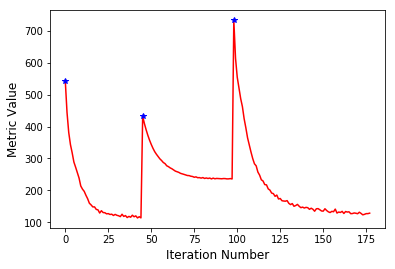


===== Registration Info =====
Final metric value: 	129.02281235721367
Last iteration: 	80
Stop condition: 
GradientDescentOptimizerv4Template: Maximum number of iterations (80) exceeded.



In [6]:
dfield_transform = registration_demons(fixed_image, moving_image, initial_transform,
                                      num_iterations = 80)


In [7]:
print(transform_info(dfield_transform))


===== Transform Info =====
Transform type: 	GaussianSmoothingOnUpdateDisplacementFieldTransform
Dimensions: 		2
Parameters: 		(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

The result is visualized here.

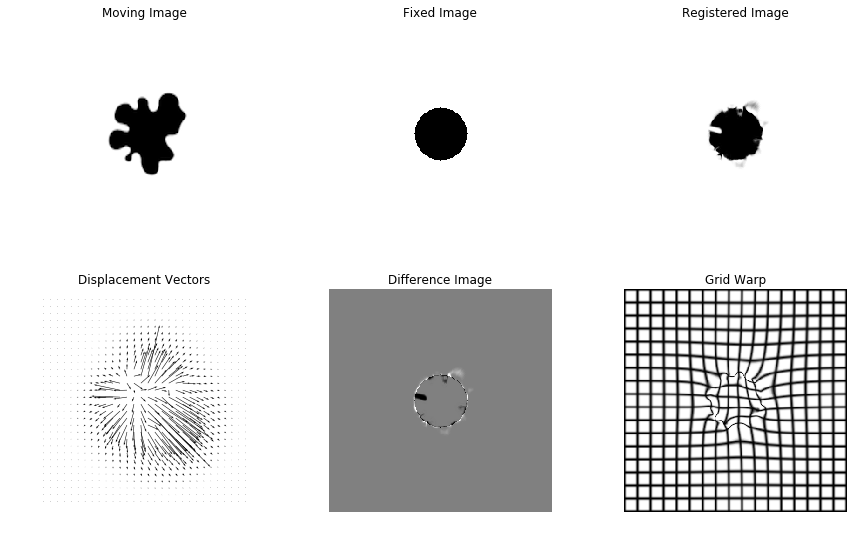

In [8]:
plot_registration(fixed_image, moving_image, dfield_transform)


## Another Example

Some typical algorithms are proved with the C and C half images. We use them here to test the deformation capabilities.


===== Image Information =====
Pixel type: 		32-bit float
Pixel channels: 	1
Dimensions: 		2
Size: 			(150, 150)
Length (mm): 		(1.0, 1.0)
Total Elements: 	22500



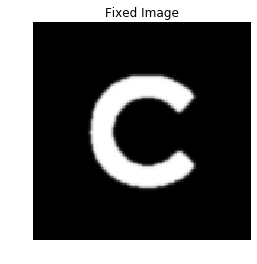


===== Image Information =====
Pixel type: 		32-bit float
Pixel channels: 	1
Dimensions: 		2
Size: 			(150, 150)
Length (mm): 		(1.0, 1.0)
Total Elements: 	22500



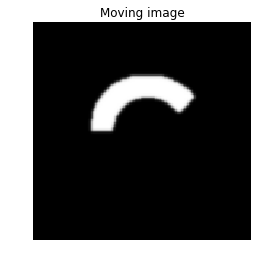

In [22]:
# Reading the images
prefix = './images/'
# prefix = '/content/registration_tutorial/images/'

fixed_image = sitk.ReadImage(prefix + 'c.png', sitk.sitkFloat32)
moving_image = sitk.ReadImage(prefix + 'chalf.png', sitk.sitkFloat32)

# Print and plot the fixed image
print(image_info(fixed_image))
imshow_2d(fixed_image, 'Fixed Image')

# Print and plot the moving image
print(image_info(moving_image))
imshow_2d(moving_image, 'Moving image')

We test again the demons algorithm with these new images.

Displacement field initialization.

In [10]:
# Create initial identity transformation.
transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
    
# The image returned from the initial_transform_filter is transferred to the transform and cleared out.
initial_transform_df2 = sitk.DisplacementFieldTransform(transform_to_displacment_field_filter.Execute(sitk.Transform(dimension, sitk.sitkIdentity)))
    
# Regularization (update field - viscous, total field - elastic).
initial_transform_df2.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=0.0) 
# initial_transform_df2.SetSmoothingOff()

Running the demos registration.

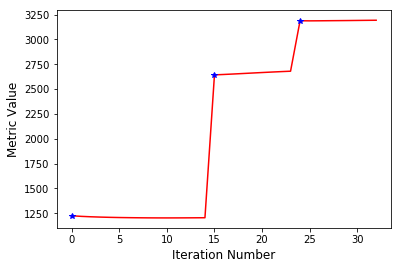


===== Registration Info =====
Final metric value: 	3194.686304965914
Last iteration: 	9
Stop condition: 
GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.



In [11]:
dfield_transform2 = registration_demons(fixed_image, moving_image, initial_transform_df2,
                                learning_rate=1.5, num_iterations = 200)

Visualize the results.

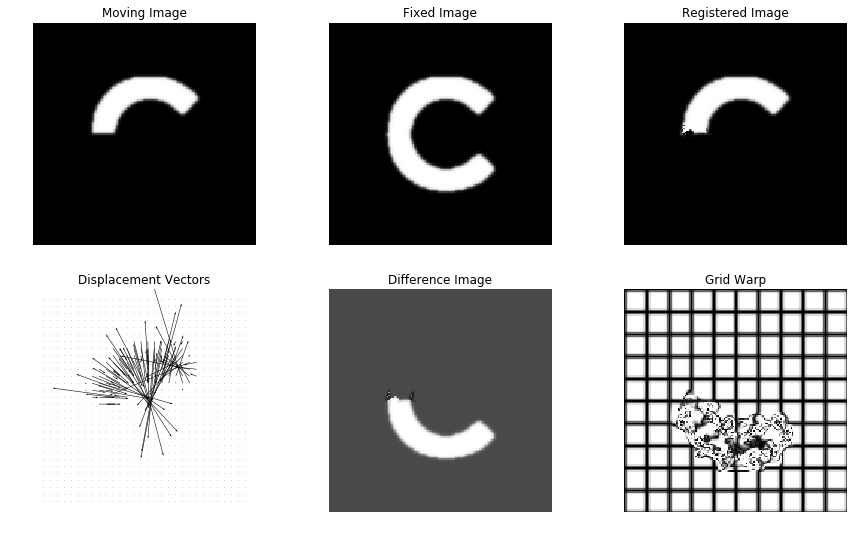

In [12]:
plot_registration(fixed_image, moving_image, dfield_transform2)

In this example, the demons algorithm fails to perform on large deformations.

## ANTS Neighborhood Correlation

This algorithm was proposed by Avants et al. The regularization in ANTS algorithm is a Symmetric Normalization. The algorithm support large diffeomorphic deformations. 

Here, we define a function with the registration algorithm using the ANTS Neigborhood Correlation. We also use the gradient descent optimizer.

In [13]:
def registration_antscorrelation(fixed_image, moving_image, transform, 
                    interpolator = sitk.sitkLinear,
                    radius = 5, sampling = 1.0,
                    num_iterations = 50, learning_rate = 1.5, 
                    multiresolution= True, verbose = True, plot = True):
    '''
    Image regristration with the ants neighborhood correlation algorithm
    Input:
        fixed_image: sitk.Image
        moving_image: sitk.Image
    Output:
        sitk.Transform
    '''
    # Define the registration object class
    registration_method = sitk.ImageRegistrationMethod()

    # Set transform, intepolation and metric
    registration_method.SetInitialTransform(transform)
    registration_method.SetInterpolator(interpolator)
    registration_method.SetMetricAsANTSNeighborhoodCorrelation(radius) 
    #a small neighborhood for each voxel between two images
    
    # Set the sampling method
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(sampling)
    
    # Set optimizer as gradient descent
    registration_method.SetOptimizerAsGradientDescent(learningRate=learning_rate, 
        numberOfIterations=num_iterations, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift() # Set appropiate scales
    
    # Setup for the multi-resolution framework.
    if multiresolution:
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[16,8,4])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Enable plotting
    if plot:
        registration_method.AddCommand(sitk.sitkStartEvent, start_register_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_register_plot)
        if multiresolution: registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                                                           update_multires_iterations)
        registration_method.AddCommand(sitk.sitkIterationEvent, 
                                   lambda: plot_register_values(registration_method))
    
    transform_estimated = registration_method.Execute(fixed_image, moving_image)
    
    # Print the information about the optimization in the registration 
    if verbose:
        info = '\n===== Registration Info ====='
        info += '\nFinal metric value: \t' + str(registration_method.GetMetricValue())
        info += '\nLast iteration: \t' + str(registration_method.GetOptimizerIteration())
        info += '\nStop condition: \n'
        info += (str(registration_method.GetOptimizerStopConditionDescription()))
        info += '\n'
        print(info)
    
    return transform_estimated

## Displacement Field

The displacement field transform is tested with this new formulation. 

Compute the initial displacement field

In [14]:
# Create initial identity transformation.
transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
    
# The image returned from the initial_transform_filter is transferred to the transform and cleared out.
initial_transform_df3 = sitk.DisplacementFieldTransform(transform_to_displacment_field_filter.Execute(sitk.Transform(dimension, sitk.sitkIdentity)))
    
# Regularization (update field - viscous, total field - elastic).
initial_transform_df3.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=0.0)

Running the ants correlation registration algorithm.

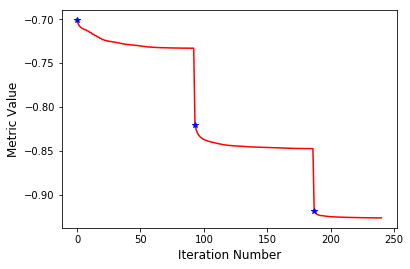


===== Registration Info =====
Final metric value: 	-0.9260577735648403
Last iteration: 	54
Stop condition: 
GradientDescentOptimizerv4Template: Convergence checker passed at iteration 54.



In [15]:
dfield_transform3 = registration_antscorrelation(fixed_image, moving_image, initial_transform_df3,
                                learning_rate=4.0, num_iterations = 200)

Visualize the results.

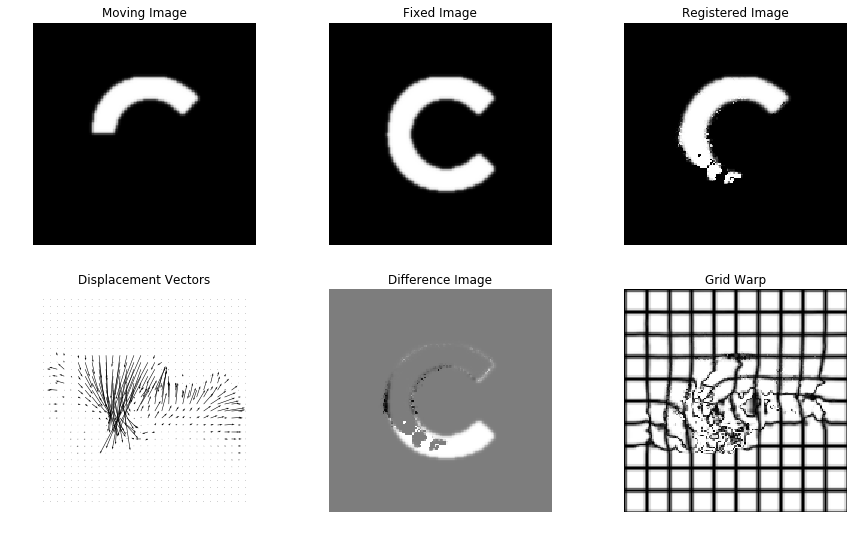

In [17]:
plot_registration(fixed_image, moving_image, dfield_transform3)

The registration is a closer solution, however is not to the desired result

### B-Spline Transform

We use a B-Spline transform with the anst correlation algorithm.

Initialize the b-spline

In [18]:
# Define bspline transform
dimension = 2
spline_order = 3
init_bspline_transform = sitk.BSplineTransform(dimension, spline_order)

Set the parameters to the b-spline transform.

In [19]:
# B-spline parameter definition
w = moving_image.GetWidth()
h = moving_image.GetHeight()
origin = [0,0]  # origin of coordinates of region where bspline is applied
direction_matrix_row_major = [1.0,0.0,0.0,1.0] # identity, mesh is axis aligned
domain_physical_dimensions = [w,h]             # dimensions where the bspline is applied
scale = 10

# Set the parameters
init_bspline_transform.SetTransformDomainOrigin(origin)
init_bspline_transform.SetTransformDomainDirection(direction_matrix_row_major)
init_bspline_transform.SetTransformDomainPhysicalDimensions(domain_physical_dimensions)
init_bspline_transform.SetTransformDomainMeshSize((10,10))

Run the registration algorithm with the b-spline transform.

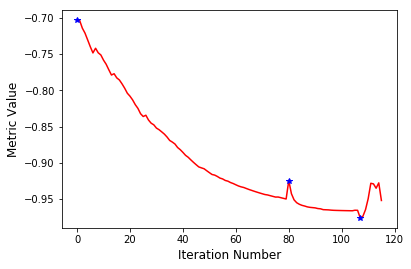


===== Registration Info =====
Final metric value: 	-0.9523364415040723
Last iteration: 	9
Stop condition: 
GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.



In [20]:
bspline_transform = registration_antscorrelation(fixed_image, moving_image, init_bspline_transform,
                                                 learning_rate = 3.0, num_iterations = 80)

Finally, visualize the results.

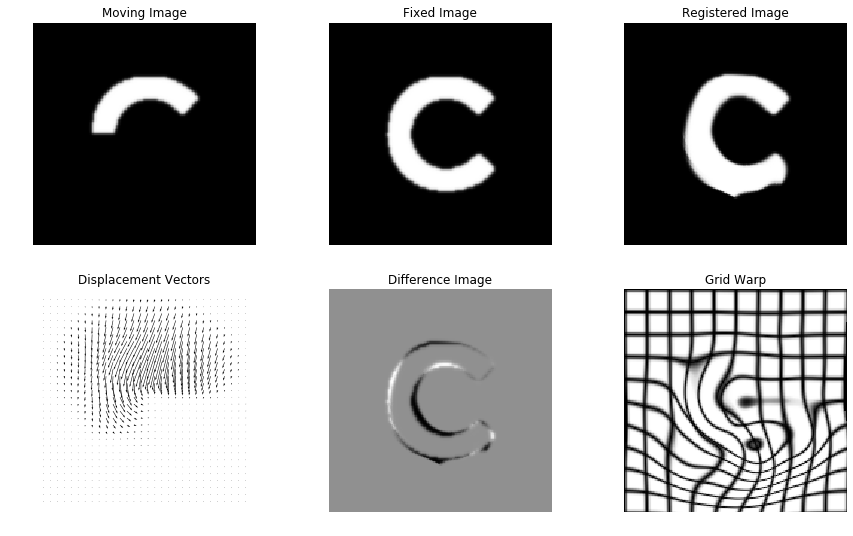

In [21]:
plot_registration(fixed_image, moving_image, bspline_transform)